# Logistic Model

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In this session we will understand:
- how logistic models can be used to classify or predict categories
- how to fit logistic models to data using maximum likelihood and gradient descent, including deriving gradients using the chain rule
- how to visualize pair plots, logistic models, histograms, and ROC curves
- using scikit-learn for doing logistic regression

In [9]:
import zipfile
import urllib.request
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logit, expit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import pandas as pd
import seaborn as sns
blue, green, red = sns.color_palette('muted', 3)
sns.set_style('ticks')
sns.set_context('talk')

In the previous section we used one feature with integer values to predict another integer value.
What if we want to predict a category or class (i.e. classify or categorize) instead of predicting a number?

There are many ways to classify data (even without a training set), and one of the most common is **logistic regression**. 
But *regression* is usually used for predicting real numbers, how is regression related to classification?
In logistic regression we are trying to regress (predict a real number) the probability of some data being in a one class and not the other. 
Logistic regression is binomial (two classes, one free variable) but it can easily be expanded to *multinomial logistic regression*, sometimes also known as *softmax regression*.

# Titanic survival data

Let's start with a concrete example.
We'll get some data related to the Titanic (courtesy of the [IPython Cookbook](http://ipython-books.github.io/) by Cyrille Rossant, originally from the [kaggle Titanic challenge](https://www.kaggle.com/c/titanic).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Cd51-1000g.gif/640px-Cd51-1000g.gif)

In [10]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/titanic.zip'
filename = '../data/titanic.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

titanic_zip = zipfile.ZipFile(filename)
with titanic_zip.open('data/titanic_train.csv') as f:
    df = pd.read_csv(f)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


OK, let's just work with three features (not just one) - `Sex`, `Age` and `Pclass`.
We will treat `Sex` as a category (0 or 1), `Age` as a number (positive intger), `Pclass` as another number, because it is the ticket class.

We will try to predict the `Survived` variable, which is simply 0 or 1.

In [11]:
features = ['Sex', 'Age', 'Pclass']
label = 'Survived'

df = df[features + [label]].copy() # what if I don't put .copy?

# encode female as 0.5 and male as -0.5: keeps distance of 1 between them, but neither is zero
female = df['Sex'] == 'female'
df.loc[female, 'Sex'] = 0.5
df.loc[~female, 'Sex'] = -0.5

# set the best class to 0 instead of 1
df['Pclass'] -= 1

# convert to float
df['Sex'] = df['Sex'].astype(float)
df['Pclass'] = df['Pclass'].astype(float)
df['Survived'] = df['Survived'].astype(float)


df = df.dropna() # remove rows with "not a number" elements
df.head()

,Sex,Age,Pclass,Survived
0,-0.5,22.0,2.0,0.0
1,0.5,38.0,0.0,1.0
2,0.5,26.0,2.0,1.0
3,0.5,35.0,0.0,1.0
4,-0.5,35.0,2.0,0.0


In [12]:
X = df[features].values
Y = df[label].values

# Data exploration

Let's look at the distribution of ages between survivers and fatalities using [matplotlib](http://matplotlib.org)'s `hist`.

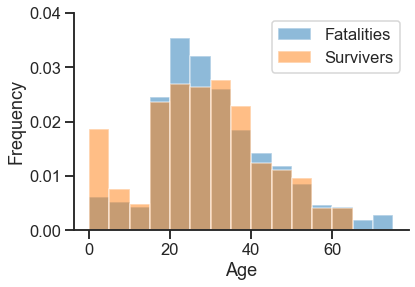

In [13]:
kws = dict(density=True, alpha=0.5, bins=np.arange(0, df['Age'].max(), 5)) # declare keyword arguments once as a dict

plt.hist(df.loc[df['Survived']==0, 'Age'], label='Fatalities', **kws) # ** unpacks the kws dict 
plt.hist(df.loc[df['Survived']==1, 'Age'], label='Survivers', **kws)
plt.legend() # labels set in the hist call
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.ylim(0, 0.04)
sns.despine()

There seems to be a difference at ages <10 and 20-30.
What if we separate by men and women?

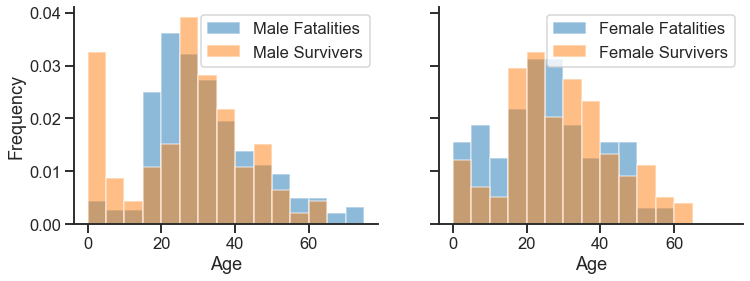

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax = axes[0]
ax.hist(df.loc[(df['Survived']==0) & (df['Sex']<0), 'Age'], label='Male Fatalities', **kws)
ax.hist(df.loc[(df['Survived']==1) & (df['Sex']<0), 'Age'], label='Male Survivers', **kws)
ax.legend()
ax.set_ylabel("Frequency")
ax.set_xlabel("Age")

ax=axes[1]
ax.hist(df.loc[(df['Survived']==0) & (df['Sex']>0), 'Age'], label='Female Fatalities', **kws)
ax.hist(df.loc[(df['Survived']==1) & (df['Sex']>0), 'Age'], label='Female Survivers', **kws)
ax.legend()
ax.set_xlabel("Age")

sns.despine()

It does seem like young men (15-25) were more likely to die and young boys (<15) were more likely to survive.
For women, it seems that young women (<15) were likely to die and then it's not very clear.

# Logistic regression

Let's try and use logistic regression to clear this up (if we can).
How does it work?

We briefly mentioned that when predicting integer values the normal distribution, and hence the *normal linear model*, is not be the best model, and demonstrated that a [GLM](https://en.wikipedia.org/wiki/Generalized_linear_model) with a Poisson distribution and an log link function intead of a normal distribution performed better.
We will do a similar trick here.

We first use a linear model (as we did before) to predict the **log-odds** for survival.

Odds here is actually short for odds-ratio (OR), which is just the ratio of the probability that something happens and the probability that it does not happen:
$$
OR = 
\frac{P(\text{Survived})}{P(\text{Died})}
$$
so when the odds-ratio is 1, both events are as likley, and when it is >1 (<1) survival (death) is more likely.

We use the odds-ratio instead of the probability itself, because it is a value between $-\infty$ and $\infty$, rather then between 0 and 1, which is important both for mathematical formality, as the linear model is unbounded, and for interpretation - the odds can be doubles again and again (2:1 becoming 4:1 becomnig 8:1...) whereas the probability cannot (what is the double of 75%?).

The log-odds, which we mark as $z$, is the natural logarithm of the odds ratio.
$$
z = 
\log{\frac{P(\text{Survived})}{P(\text{Died})}}
$$
Why use the log-odds? Because (i) it is more mathematically convinient, as log-odds is symmetric in the probability, whereas odds is not, and (ii) it is easier to interpret, as we will see below.

So to use a linear model for predicting the log-odds, we have $m$ features, $x_1, x_2, \ldots, x_m$, and we try to estimate coefficients $\mathbf{W} = (b, a_1, \ldots, a_m)$ such that
$$
z = b + a_1 x_1 + \ldots + a_m x_m
$$
or 
$$
z = \mathbf{X} \cdot \mathbf{W}
$$
gives us a good prediction of the true log-odds.

From the log-odds we can find the probability for the event to occur using the *logisitic* (hence the name of the method!) or the *expit* function (same function, different name):
$$
P(\text{Survived}) = expit(z) = \frac{1}{1+e^{-z}}
$$

In [7]:
def logodds(X, W, b):
    Z = X @ W + b
    return Z

In [8]:
W = np.array([1, 1, 1])
b = 1
print(logodds(X, W, b)[:5])

[24.5 39.5 29.5 36.5 37.5]


# Maximum likelihood

Now we want to find suitable $a_i$ such that we make a good prediction. 
We'll use *maximum likelihood* again.

Given data $(x, y)$ where $x = (x_1, \ldots, x_m)$ are some numbers and $y$ is either 0 or 1, the logistic model provides us an estimate $\widehat y$

$$
\widehat{y} = P(y=1)=\frac{1}{1+e^{-z}} = \frac{1}{1+e^{-b -a_1 x_1 - \ldots -a_m x_m}}
$$

The likelihood of this model is

$$
\mathcal{L}(b, a_1, \ldots, a_m \mid x_1, \ldots, x_m, y) = 
P(y \mid b, a_1, \ldots, a_m, x_1, \ldots, x_m) = 
\cases{
    \widehat{y}, & y=1 \\
    1-\widehat{y}, & y=0
}
$$

If we have many $(x,y)$ pairs, and we will **assume that each pair is independent** (which maybe we can't always do, and specifically in the Titanic case we probably shouldn't do, but ok) then the joint likelihood of all the pairs is just the product of all the pair likelihoods: the product is used because the joint probability of independent events occuring is the product of their occurence probabilities.
Writing the set of $x$s as $X$ and the corresponding set of $y$s as $Y$, and because $y$ are either 0 or 1,

$$
\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y) = 
\prod_{i} {(\widehat{y}_i)^{y_i} \; (1-\widehat{y}_i) ^{1-y_i}}
$$

We'll use the log-likelihood because otherwise we will have to deal with a product of really small numbers; so we take the sum of the log of the likelihood $\mathbf{L}$ of the the $(x, y)$ pairs (sum because the log of products is the sum of logs). The use of log here is not "magic", it's a mathematical convenience. It just happens that "log-likelihood" sounds very impressive.

$$
\log{\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y)} = 
\sum_{i} {y_i \log{\widehat{y}_i} + (1-y_i) \log{(1-\widehat{y}_i)}}
$$

This is very similar to the negative of an information theory function called [*cross entropy*](https://en.wikipedia.org/wiki/Cross_entropy), and we usually average it over all the samples so that we can compare cross entropies between datasets of different size:

$$
\mathbf{J}(b. a_1, \ldots, a_m, X, Y) = -\frac{1}{n} \log{\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y)}
$$

where $n$ is the number of samples in $X,Y$.

### Numerical stability

Due to numerical issues when using very small or very large numbers, we should play around with the definition a little bit to find an expression that we can calculate with good numerical stability.

Note that
$$
\log{\widehat{y}} = -\log{\Big(1 + e^{-z}\Big)}  = -\log{\Big(1 + e^{-z}\Big)} \\
\log{(1-\widehat{y})} = -z - \log{\Big(1 + e^{-z}\Big)}
$$
and therefore
$$
y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})} = \\
-y \log{\Big(1 + e^{-z}\Big)} + (1-y)\Big(-z - \log{\Big(1 + e^{-z}\Big)}\Big) = \\
(1-y)z - \log{\Big(1 + e^{-z}\Big)}
$$

Finally,
$$
\log{\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y)} = 
\sum_{(x,y) \in (X,Y)} {-z (1-y) - \log{\Big(1 + e^{-z}\Big)}},
$$
where $z=\text{log-odds} = a_1 x_1 + \ldots + a_n x_n$.

# Exercise: cross-entropy

Implement the cross entropy function.

You can check the [solution](../solutions/logistic_model.py).

In [9]:
def cross_entropy(X, Y, W, b):
    # your code here

In [10]:
cross_entropy(X, Y, W, b)

19.45733884278718

The solution file has two implementations: `_cross_entropy` in pure-python with generator expression and `cross_entropy` using NumPy arrays.

Guess which one is faster and compare to your implementation if you want.

# Gradient descent and the chain rule

Now we can minimize the cross entropy using gradient descent.
We need to calculate the derivative of the cross entropy with regards to $a_i$.
We will use the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$
f(g(x))' = f'(g(x)) \cdot g'(x), 
$$

which is easier to write as 

$$
\frac{dx}{dy} = \frac{dx}{dz} \cdot \frac{dz}{dy}
$$

because then we can eliminate fractions as if these were fractions and not [infinitesimals](https://en.wikipedia.org/wiki/Infinitesimal).

Remember that $z=\text{log-odds} = a_0 + a_1 x_1 + \ldots + a_m x_m$ and $\mathbf{J}$ is the cross entropy function which we want to minimize.

Then 
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k}
$$

The easiest one is:

$$
\frac{\partial z}{\partial a_k} = x_k
$$

The derivative of the logistic function is (you can verify later):

$$
\frac{\partial \widehat y}{\partial z} = \widehat y ( 1-\widehat y )
$$

Next, because $\frac{d}{dx} log(x) = \frac{1}{x}$ (again, you can verify this),

$$
\frac{\partial \mathbf{J}}{\partial \widehat y} = 
- \frac{\partial}{\partial \widehat y} \big(y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})}\big) = \\
-y \cdot \frac{1}{\widehat y} + (1-y) \cdot \frac{1}{1-\widehat y} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)}
$$

Putting it all together,
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)} \cdot \widehat y ( 1-\widehat y ) \cdot x_k = \\
(\widehat y - y) \cdot x_k
$$

which you have to admit is pretty cool: this is the residual (i.e. difference between the predicted and oberverd probabilities, $\widehat y - y$), so 0 when you got it right and 1 or -1 when you got it completely wrong, multiplied by the stength of the signal, so that strong signals (large $x_k$) have a stonger gradient and stonger effect on the result.

This was the gradient for a single sample. We average it over all samples to get a good estimate of the "real gradient" (law of large numbers etc.).

# Exercise: gradient descent

See below the implementation of the `gradient_descent` function, similar to the one we had in the [linear model session](linear-model.ipynb), which returns updated values for the coefficients `W` and the bias (intercept) `b` based on one iteration of the gradient descent algorithm.

The function is missing a computation of `db`, the derivative of the cross entropty with respect to the bias $\frac{\partial \mathbf{J}}{\partial b}$.

**Complete the missing part**.

You can check the [solution](../solutions/logistic_model.py).

In [13]:
def gradient_descent(X, Y, W, b, η=0.01):
    Yhat = expit(logodds(X, W, b))
    δ = Yhat - Y
    dW = X.T @ δ / δ.shape[0]
    # your code here #
    ##################
    assert dW.shape == W.shape
    return W - η * dW, b - η * db

When your solution is ready, comment out the first line of the next cell and run it.

In [14]:
W, b = gradient_descent(X, Y, W, b)
print(W)
print(b)

[1.00206753 0.81814626 0.99119069]
0.9940755417286117


# Fitting the logistic model

Fitting the model is done in much the same way as we did with the linear model - just have to choose initial coefficeints, different stopping condition, and adjust to the API of the new `gradient_descent` function.

This time we stop when the difference in cross entropy between two iterations is smaller than some value ($10^{-4}$).

In [15]:
def logistic_model(X, Y, W=(1, 1, 1), b=1, iters=70000):
    W = np.array(W)
    for t in range(iters+1):
        W, b = gradient_descent(X, Y, W, b)
        if t % (iters//10) == 0:
            J = cross_entropy(X, Y, W, b)
            print("{}: J={:.6f}, W={}, b={:.4f}".format(t, J, W, b))        
    return W, b

In [16]:
W, b = logistic_model(X, Y)

0: J=16.138615, W=[1.00206753 0.81814626 0.99119069], b=0.9941
7000: J=0.458089, W=[ 2.34412618 -0.02125825 -0.99875103], b=1.6301
14000: J=0.454292, W=[ 2.45377245 -0.02946886 -1.15259186], b=2.0941
21000: J=0.453515, W=[ 2.48855149 -0.03334021 -1.22299454], b=2.3080
28000: J=0.453339, W=[ 2.50530107 -0.03518222 -1.25655783], b=2.4097
35000: J=0.453298, W=[ 2.51374367 -0.03607299 -1.27284646], b=2.4590
42000: J=0.453288, W=[ 2.51797098 -0.03650804 -1.28081906], b=2.4831
49000: J=0.453286, W=[ 2.52007293 -0.03672163 -1.28473755], b=2.4949
56000: J=0.453285, W=[ 2.52111408 -0.03682676 -1.28666739], b=2.5007
63000: J=0.453285, W=[ 2.5216288  -0.03687858 -1.28761878], b=2.5036
70000: J=0.453285, W=[ 2.52188304 -0.03690413 -1.28808805], b=2.5050


In [17]:
print("Odds-ratios:")
print("bias:\t{:.3f}".format(np.exp(b)))
for i, var in enumerate(features):
    print("{}:\t{:.3f}".format(var, np.exp(W[i])))

Odds-ratios:
bias:	12.244
Sex:	12.452
Age:	0.964
Pclass:	0.276


We can interpret these results as follows:
- a baby of indetermined sex in first class ($\mathbf{X}=(0,0,0)$) was 12-fold more likely to survive than to die
- women were 12-fold more likely to survive than men
- older passengers were less likely to survive: each additional year reduced odds of survival by 3.5%
- passengers with expensive tickets were much move likely to survive: each reduction in class reduced survival by ~73%.


## Model prediction

Our model outputs *probabilities*, and we need to convert these to classes. 
We will just decide that if the predicted survival probability is 0.5 then that person survived.

A good score for a classification problem is the *accuracy*, which tells us the fraction of cases in which our model agrees with the truth.

In [19]:
Yhat = expit(logodds(X, W, b))
accuracy = ((Yhat>0.5) == Y).mean()

print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 78.85%


# COVID-19 fatality data

We will do another example, this time using COVID-19 data.

The dataset includes case details for over 7500 patients from Singapore, Hong Kong, Philippines, and South Korea. 
Details include age, sex, nationality, status, and dates.

Data obtained from [dolthub](https://www.dolthub.com/repositories/Liquidata/corona-virus/doc/master/README.md).

In [20]:
df = pd.read_csv("../data/covid-19_case_details.csv")
df.head()

,source,case_id,case_name,age,sex,nationality,current_status,symptomatic_date,confirmed_date,recovered_date,place_id,province_state,country_region,latitude,longitude
0,https://coronavirus-ph-api.now.sh/cases,1,NaN,38.0,F,Chinese,Recovered,NaN,2020-01-30 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
1,https://coronavirus-ph-api.now.sh/cases,2,NaN,44.0,M,Chinese,Died,NaN,2020-02-02 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
2,https://coronavirus-ph-api.now.sh/cases,3,NaN,60.0,F,Chinese,Recovered,NaN,2020-02-05 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
3,https://coronavirus-ph-api.now.sh/cases,4,NaN,48.0,M,Filipino,Recovered,NaN,2020-03-05 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
4,https://coronavirus-ph-api.now.sh/cases,5,NaN,62.0,M,Filipino,Died,NaN,2020-03-05 00:00:00,NaN,48,NaN,Philippines,13.0,122.0


## Data formatting for linear model

We convert the places names from a categorical (text) variable to four dummy varaibles that take values 0 or 1. We do this because logistic regression takes numeric values. By having one "boolean" variable per country, we will be able to estimate the effect of each place on probability to die from COVID-19.

In [21]:
dummies = pd.get_dummies(df['country_region'])
dummies = dummies.rename(columns={'China':'Hong Kong', 'Korea, South':'South Korea'})
countries = dummies.columns
df = pd.concat((df, dummies), axis=1)
dummies.head()

,Hong Kong,South Korea,Philippines,Singapore
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


There are multiple rows for some cases (i.e. patients), so we take the last row for each case. Also, the case identifiers are unique _per country_.

In [22]:
df = df.groupby(['place_id', 'case_id']).last()
df = df.reset_index()

We filter in only cases that ended with recovery or death, the rest of the cases are undertermined yet.

We then create a boolean column for recovery.

In [23]:
dead = df['current_status'].isin(['deceased', 'Died', 'Dead', 'deceased', 'Desceased'])
recovered = df['current_status'].isin(['Released', 'released', 'Recovered'])
df = df[dead | recovered]
df['recovered'] = recovered.astype(int)

We convert sex to an integer, and extract only the variables of interest.

In [24]:
female = df['sex'] == 'F' 
df.loc[female, 'sex'] = 0.5
df.loc[~female, 'sex'] = -0.5

var_names = ['recovered', 'sex', 'age'] + countries.tolist()
df = df[var_names].copy() # what if I don't put .copy?
df = df.dropna() # remove rows with "not a number" elements
df.head()

,recovered,sex,age,Hong Kong,South Korea,Philippines,Singapore
1,1,-0.5,66.0,0,0,0,1
2,1,0.5,53.0,0,0,0,1
3,1,-0.5,37.0,0,0,0,1
4,1,-0.5,36.0,0,0,0,1
5,1,0.5,56.0,0,0,0,1


We extract the features to `X` and the target to `Y`.

In [25]:
X = df[var_names[1:]].values.astype(float)
Y = df[var_names[0]].values.astype(float)

## Data visualization

We can plot the distrubtion of cases.

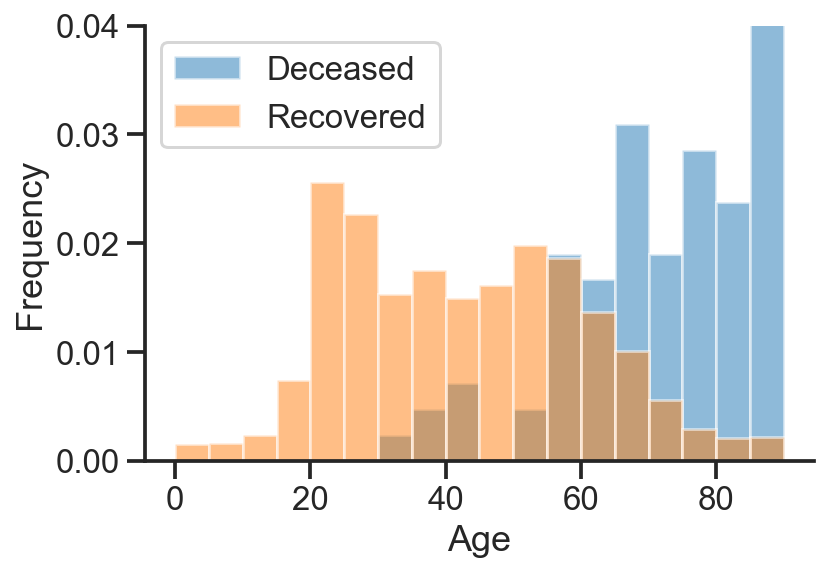

In [26]:
kws = dict(density=True, alpha=0.5, bins=np.arange(0, df['age'].max(), 5)) # declare keyword arguments once as a dict

plt.hist(df.loc[df['recovered']==0, 'age'], label='Deceased', **kws) # ** unpacks the kws dict 
plt.hist(df.loc[df['recovered']==1, 'age'], label='Recovered', **kws)
plt.legend() # labels set in the hist call
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.ylim(0, 0.04)
sns.despine()

## Model fitting with Scikit-learn

Now we fit a logistic model to the data. 
We will use **Scikit-learn** this time: specifically, the `sklearn.linear_model.LogisticRegression` model.

In [29]:
model = LogisticRegression(penalty='none', fit_intercept=True) # by default, scikit-learn uses l2 penalty
model.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Here are the effects of the features, using the model coefficients.

In [30]:
print("{:<10}\t{:>11.4f}".format("intercept", np.exp(model.intercept_)[0]))
for var, coef in zip(var_names[1:], np.exp(model.coef_).ravel()):
    print("{:<10}\t{:>11.4f}".format(var, coef))

intercept 	2205129.5884
sex       	     4.2723
age       	     0.8991
Hong Kong 	778623.6593
South Korea	     0.0061
Philippines	     0.0004
Singapore 	1138895.3865


We see that:
- intercept: for a baby with indeterminate sex and country, the death rate is 1 to 2.2 million
- females are about 4.3 times more likely to survive,
- age reduces survival by ~10% per year
- Hong Kong and Singapore are much safer, but this may be due to the effect that we have no data about deceased there.

## Classification threshold

To find a good threshold for classification, lets look at the historgram of probability for death, applied to recovered (blue) and deceased (red) cases.

Threshold: 0.06


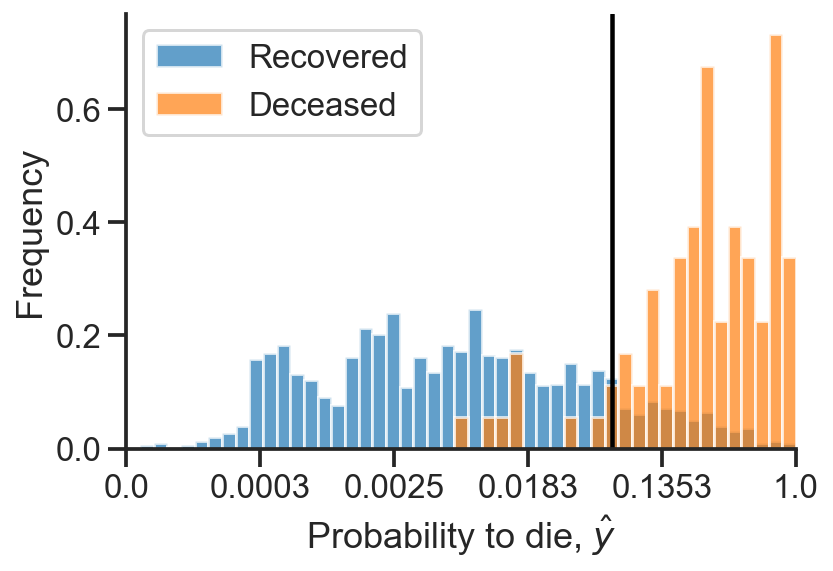

In [32]:
logPdeceased = model.predict_log_proba(X)[:,0] # probabilities are pretty low so we use log-probabilities

bins = np.linspace(-10, 0, 50)
plt.hist(logPdeceased[Y==1], bins=bins,density=True, alpha=0.7, label='Recovered');
plt.hist(logPdeceased[Y==0], bins=bins,density=True, alpha=0.7, label='Deceased')
plt.xlabel(r'Probability to die, $\hat{y}$')
plt.ylabel('Frequency')
xticks = plt.xticks()[0]
plt.xticks(xticks, np.round(np.exp(xticks), 4))
plt.xlim(bins.min(), bins.max())
plt.axvline(-2.75, color='k')
print("Threshold: {:.2f}".format(np.exp(-2.75)))
plt.legend()
sns.despine()

The threshold we pick (i.e. 0.06) can balance between the probability to give an incorrect positive answer and the probability to give a correct positive answer.
These are called the false-positive rate and true-positive rates.

Think for example on what we would like to do if we are trying to predict if a person is has a disease. 
You might consider that it is preferable to sometimes tell someone they are ill when they are actually not, and then running more tests, rather than sometimes telling people they are healthy when they are actually ill, and having them cause damage to themselves or others.

Let's suppose that a positive answer is "person survived the Titanic" that is $y=1$ or `truth==1` and use *scikit-learn*'s utility to calculate and plot the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

An "ideal" model will shoot directly to the top, that is, have maximum TPR for any FPR.
A "random" or "naive" model can be expected to follow the dashed line.

Indeed if we look at the ROC curve, the threshold we choose is right on the "knee" of the curve.

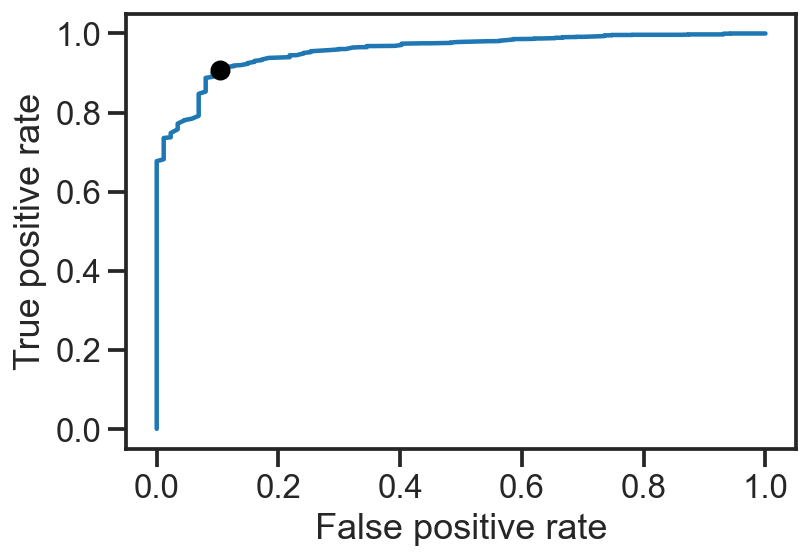

In [33]:
Yhat = model.predict_proba(X)[:,1]

fpr, tpr, thresholds = roc_curve(Y, Yhat)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
idx = (thresholds < 1-0.06).argmax()
plt.plot(fpr[idx], tpr[idx], 'ok');

We plot the probability to die for each age in each countries, separated by sex.

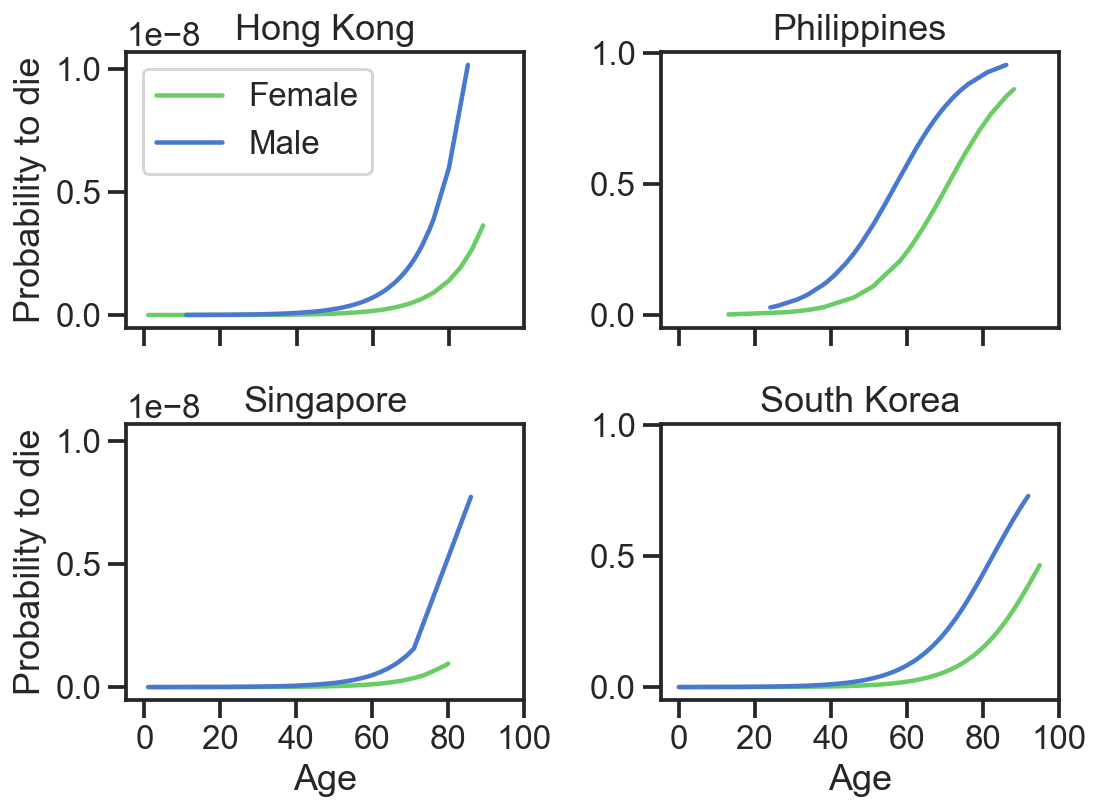

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey='col')
for country, ax in zip(sorted(countries), axes.flat):
    df_ = df[df[country]==1]
    df_ = df_.sort_values('age')
    X_ = df_[var_names[1:]]
    Y_ = df_[var_names[0]]
    Pdie_ = model.predict_proba(X_)[:,0]
    female = df_['sex'] > 0
    ax.plot(X_.loc[female, 'age'], Pdie_[female], '-', color=red, label='Female')
    ax.plot(X_.loc[~female, 'age'], Pdie_[~female], '-', color=blue, label='Male')
    ax.set(title=country)
axes[0,0].legend(loc='upper left')
axes[0,0].set(ylabel='Probability to die')
axes[1,0].set(xlabel='Age', ylabel='Probability to die', xticks=[0, 20, 40, 60, 80, 100])
axes[1,1].set(xlabel='Age', xticks=[0, 20, 40, 60, 80, 100])
fig.tight_layout()

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.2**.
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (a similar Titanic example is shown in chapter "Predicting who will survive on the Titanic with logistic regression"). 
- Scikit-learn documentation has a [tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#classification) using the classical Iris dataset, with examples for other classification methods other than logistic regression.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)